# Classification of human activity from motion sensor data

## Description

This dataset includes time-series data generated by accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate). 

- Data was collected with an iPhone 6s kept in the participant's front pocket using *SensingKit* which collects information from *Core Motion* framework on iOS devices. 
- All data collected in 50Hz sample rate. 
- A total of 24 participants in a range of gender, age, weight, and height were recorded
- Participants performed 6 activities in 15 trials in the same environment and conditions: *downstairs, upstairs, walking, jogging, sitting,* and *standing*. 

### Task

- The primary task is to **build a classifier for human activity** based on motion data coming from the mobile device. Also, make sure that you construct a testing set based on different persons in order to test whether the model generalizes well.

- The secondary task is to **build a fingerprint generator** that would allow for identification of a person using (wearing) a mobile device\*


 \* *This dataset was taken from the project that aims to build countermeasures for the second task's goal. It tries to anonymise motion data\** so that the identification is not possible but the data is still usable for "safe tasks" like activity recognition. The complexity of such anonymisation model is beyond today's lesson but it is still useful to think of possible solutions for such a problem.*

 \** *The dataset is anonymised (names of participants and unknown)* 


### Acknowledgement

Mohammad Malekzadeh, Richard G.Clegg, Andrea Cavallaro and Hamed Haddadi - *Mobile Sensor Data Anonymization*

[GitHub repository](https://github.com/mmalekzadeh/motion-sense)

## Imports & Drive mount

In [2]:
%tensorflow_version 2.x
%matplotlib inline

import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [1]:
matplotlib.rcParams['figure.figsize'] = (15, 6)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

NameError: ignored

## Dataset loading & basic analysis

In [3]:
!wget https://raw.githubusercontent.com/mlcollege/time-series-analysis/master/data/motion-sensing/A_DeviceMotion_data.zip

--2022-10-26 14:30:42--  https://raw.githubusercontent.com/mlcollege/time-series-analysis/master/data/motion-sensing/A_DeviceMotion_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73696396 (70M) [application/zip]
Saving to: ‘A_DeviceMotion_data.zip’

A_DeviceMotion_data 100%[===================>]  70.28M   316MB/s    in 0.2s    

2022-10-26 14:30:45 (316 MB/s) - ‘A_DeviceMotion_data.zip’ saved [73696396/73696396]



In [4]:
import zipfile

DATA_FOLDER = '/content/MotionData'

with zipfile.ZipFile('/content/A_DeviceMotion_data.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_FOLDER)

In [5]:
walking_sample = pd.read_csv(DATA_FOLDER + '/A_DeviceMotion_data/wlk_7/sub_1.csv')
walking_sample

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,0,-1.711140,-1.429168,-2.591433,-0.139767,0.989987,0.019745,-0.350593,-0.511691,-0.865217,0.091702,0.415881,0.093689
1,1,-1.787917,-1.414171,-2.630956,-0.152324,0.987759,0.033602,-0.550553,-2.243217,-0.582409,0.367412,0.004566,-0.106082
2,2,-1.897323,-1.399331,-2.706668,-0.161610,0.985336,0.054729,-0.931014,-1.358033,-0.503947,0.172093,-0.217483,-0.163387
3,3,-2.018375,-1.383279,-2.813421,-0.168058,0.982470,0.080680,-1.304668,-0.541368,-0.346302,0.004957,-0.237566,-0.019080
4,4,-2.124395,-1.364054,-2.913092,-0.174613,0.978705,0.107922,-1.278349,-0.434722,-0.398598,-0.040292,-0.241461,0.015201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5434,5434,2.740007,-0.813391,2.707558,0.268549,0.726621,0.632380,-4.759731,3.035508,-1.614411,-0.690515,0.160006,-0.301676
5435,5435,2.855015,-0.747426,2.792285,0.207323,0.679753,0.703529,-3.553162,2.566744,-1.584018,-0.628969,0.368785,-0.986305
5436,5436,2.934443,-0.706561,2.835642,0.156434,0.649222,0.744338,-1.892946,2.297347,-0.922597,-0.323685,0.392786,-0.913802
5437,5437,2.977191,-0.671725,2.868442,0.128106,0.622337,0.772195,-1.976241,0.373779,-0.930328,-0.129754,0.223900,-0.717584


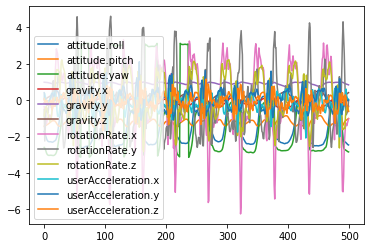

In [6]:
walking_sample.iloc[:500,1:].plot()

In [7]:
full_dataset = []
for dirpath, dirnames, filenames in tqdm(list(os.walk(DATA_FOLDER + '/A_DeviceMotion_data'))):
    for filename in filenames:
        motion_data = pd.read_csv(dirpath + os.sep + filename).iloc[:,1:]       
        subject_code = int(filename.split('.')[0].split('_')[1]) 
        activity_code = dirpath.split(os.sep)[-1].split('_')[0]
        full_dataset.append((activity_code, subject_code, motion_data))

  0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
from collections import Counter

activities, participants, motion_data = zip(*full_dataset)

print(Counter(activities))
activities = set(activities)

print(Counter(participants))
participants = set(participants)

Counter({'dws': 72, 'wlk': 72, 'ups': 72, 'sit': 48, 'std': 48, 'jog': 48})
Counter({7: 15, 5: 15, 23: 15, 3: 15, 11: 15, 14: 15, 17: 15, 1: 15, 24: 15, 22: 15, 21: 15, 4: 15, 8: 15, 19: 15, 18: 15, 15: 15, 12: 15, 9: 15, 16: 15, 20: 15, 2: 15, 10: 15, 6: 15, 13: 15})


In [9]:
all_trials = pd.concat(motion_data)

trials_by_activity = {act: [] for act in activities}
trials_by_participant = {p: [] for p in participants}

for act, p, trial in full_dataset:
    trials_by_activity[act].append((p, trial))
    trials_by_participant[p].append((act, trial))

^ As described at the beginning, the dataset contains 6 activities, 24 participants and 15 trials for 
each participant.

For solving the primary task, you would need to perform the following:
- **Split the data** into trainnig & testing parts (I suggest to split according to participants)
- **Slice the motion data** into smaller chunks/sequences (the model does not need the whole trial to predict the right activity (a few seconds should be enough)
- Make sure the **data is in good conditions** (no missing values, no huge differences between features)
- **Build and train a model** (LSTM or a flat NN)
- **Evaluate the model** on testing data (confusion matrix would be a nice result)

*Additionally, you can stress-test the model on slices of different size then used in the training ...*